# Predicting Cancer Propensity of Breast Cell Samples

<i>By Diego Ramallo</i>

Prompt: Your task is to develop a model that predicts whether a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell. Here's more info about the column names:

1. Sample code number: id number 
2. Clump Thickness: 1 - 10 
3. Uniformity of Cell Size: 1 - 10 
4. Uniformity of Cell Shape: 1 - 10 
5. Marginal Adhesion: 1 - 10 
6. Single Epithelial Cell Size: 1 - 10 
7. Bare Nuclei: 1 - 10 
8. Bland Chromatin: 1 - 10 
9. Normal Nucleoli: 1 - 10 
10. Mitoses: 1 - 10 
11. Class: (2 for benign, 4 for malignant)

[Formatting Data](#Formatting Data)

[Visualizing data](#Visualizing Data)

[Splitting the Data](#Splitting the Data)

[Logistic Regression](#Logistic Regression)

[Model Validation](#Model Validation)

In [134]:
import numpy as np#Math library
import pandas as pd#Table library
import matplotlib.pyplot as plt#Plotting library
import pandas as pd
import warnings
import seaborn as sns#Plotting library
warnings.filterwarnings('ignore')#Gets rid of popup warnings
%matplotlib nbagg

<a id='Formatting Data'></a>

## Formatting Data


In [4]:
columns= ['id','clThick', 'unifSize', 'unifShape', 
          'margAdhesion', 'epithSize','bareNuclei',
          'blandChrom','normNuc','mitoses','class']

data= pd.read_csv('breast-cancer-wisconsin.csv', names= columns)
data.head(3)

,id,clThick,unifSize,unifShape,margAdhesion,epithSize,bareNuclei,blandChrom,normNuc,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2


In [6]:
data.dtypes

id               int64
clThick          int64
unifSize         int64
unifShape        int64
margAdhesion     int64
epithSize        int64
bareNuclei      object
blandChrom       int64
normNuc          int64
mitoses          int64
class            int64
dtype: object

In [8]:
data.describe()

,id,clThick,unifSize,unifShape,margAdhesion,epithSize,blandChrom,normNuc,mitoses,class
count,6.990000e+02,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,1.071704e+06,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,6.170957e+05,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.706885e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238298e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [12]:
#Data looks great aside from having to convert the bareNuclei column into numeric!
data['bareNuclei']= data['bareNuclei'].convert_objects(convert_numeric=True)
data.dtypes

id                int64
clThick           int64
unifSize          int64
unifShape         int64
margAdhesion      int64
epithSize         int64
bareNuclei      float64
blandChrom        int64
normNuc           int64
mitoses           int64
class             int64
dtype: object

In [13]:
#Cool! Now we can get started
data.shape

(699, 11)

In [22]:
print data['class'].unique()

[2 4]


In [24]:
#Ok great it's a binary classification problem, let's see how balanced the target classes are
print 'Number of 2s: ',  len(data[data['class']==2])
print 'Number of 4s: ',  len(data[data['class']==4])

Number of 2s:  458
Number of 4s:  241


Oof, so 2's outnumber 4's approximately 2:1.  In order to improve the quality of our dataset we'll need to account for the class imbalance in our dataset by either weihing the clases differently or by oversampling our minority class. We'll do that after we split our data.  


<a id='Visualizing Data'></a>

## Visualizing Data

<a id='Splitting the Data'></a>

## Splitting the Data

In [29]:
#First we'll separate our training data from the validation/test subset
#Then we'll split the valid/test subset separately
from sklearn.cross_validation import KFold, train_test_split

train, validTest= train_test_split(data, test_size= 0.5, random_state= 42)
valid, test= train_test_split(validTest, test_size= 0.5, random_state= 42)

In [30]:
#Now let's check balance on training again
print 'Number of 2s: ',  len(train[train['class']==2])
print 'Number of 4s: ',  len(train[train['class']==4])

Number of 2s:  232
Number of 4s:  117


Class imbalance still seems to be in the training set, cool. Logistic regression has an option to weigh the classes to correct for the imbalance. Let's try that first since it is also great for inference. 


<a id='Logistic Regression'></a>

## Logistic Regression


Before doing too much we need to standardize our features before feeding them into the model. This requires that we split the features and classes first

In [32]:
trainX= train.ix[:, train.columns != 'class']
trainY= train['class']

In [34]:
#Now we'll normalize our trainX (everything but id's)
from sklearn import preprocessing
trainX= trainX.fillna(trainX.mean())
trainX= preprocessing.scale(trainX.ix[:, trainX.columns != 'id'])

Ok cool, filling the nans with the mean allowed us to rescale, will get back to this later

In [38]:
#Now let's finally try training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

logreg= LogisticRegression(class_weight = 'balanced')

In [39]:
logreg.fit(trainX, trainY)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [45]:
#Now let's try predicting on our test set
testX= test.ix[:, test.columns != 'class']
testY= test['class']

testX= testX.fillna(testX.mean())

testX= preprocessing.scale(testX.ix[:, testX.columns != 'id'])

logregPred= logreg.predict(testX)


<a id='Model Validation'></a>

## Model Validation

<IPython.core.display.Javascript object>


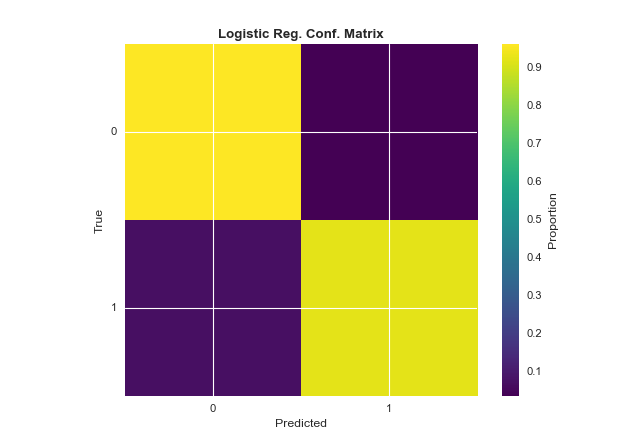

In [53]:
confMatrix= confusion_matrix(testY, logregPred)#Confusion matrix for logistic regression model (4 features)
cmNorm = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]#Normalized model

plt.imshow(cmNorm, interpolation='nearest', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.xticks(np.arange(0,2))
plt.yticks(np.arange(0,2))
plt.colorbar(label='Proportion')
plt.title('Logistic Reg. Conf. Matrix', fontweight= 'bold')

In [56]:
#To make it easier to understand, let's look at the components of a confusion matrix table
confMatrix

array([[103,   4],
       [  5,  63]])

In [123]:
trueNeg= confMatrix[0][0]
falsePos= confMatrix[0][1]
falseNeg= confMatrix[1][0]
truePos= confMatrix[1][1]

In [62]:
precision= truePos/float(truePos+falsePos)
recall= truePos/float(truePos+falseNeg)

print 'Precision: ', precision, 'Recall: ', recall

Precision:  0.940298507463 Recall:  0.926470588235


We can see that for each one of these metrics our performance seems to be doing well, as is represented in our confusion matrix figure. Now let's calculate the ROC curves and precision recall curves. To do this we'll need to get the predicted probabilities for our model. In the process we'll also calculate the area under the curve for each.

In [125]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

#Need to convert our responses to binary (2 is now 0, 4 is now 1)
testYBinary= (testY.values/2)-1#Could also use label_binerize fxn

#Predicted probabilities
logPredprob= logreg.predict_proba(testX)

#ROC metrics
logregFpr, logregTpr, rocThresh= roc_curve(testYBinary,logPredprob[:,1])

#Precision recall metrics
logregPrecision, logregRecall, precrecThresh= precision_recall_curve(testYBinary,logPredprob[:,1])

<IPython.core.display.Javascript object>


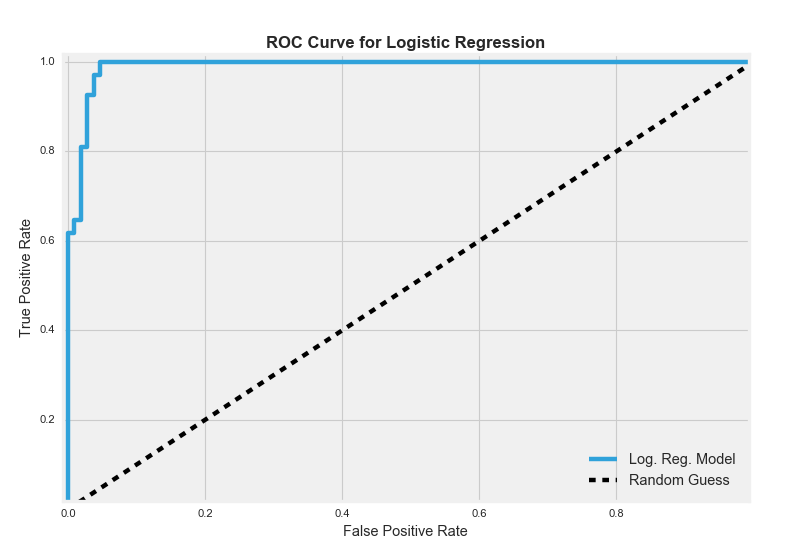

In [126]:
#ROC Curve
plt.style.use('fivethirtyeight')
logregRocPlot,= plt.plot(logregFpr,logregTpr, label='3 Feat. Log. Reg. Model')
guessPlot,= plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate', fontsize= 13)
plt.ylabel('True Positive Rate', fontsize= 13)
plt.title('ROC Curve for Logistic Regression', size= 15, fontweight= 'bold')
plt.legend([logregRocPlot, guessPlot], ['Log. Reg. Model','Random Guess'], loc=4, fontsize= 13)

<IPython.core.display.Javascript object>


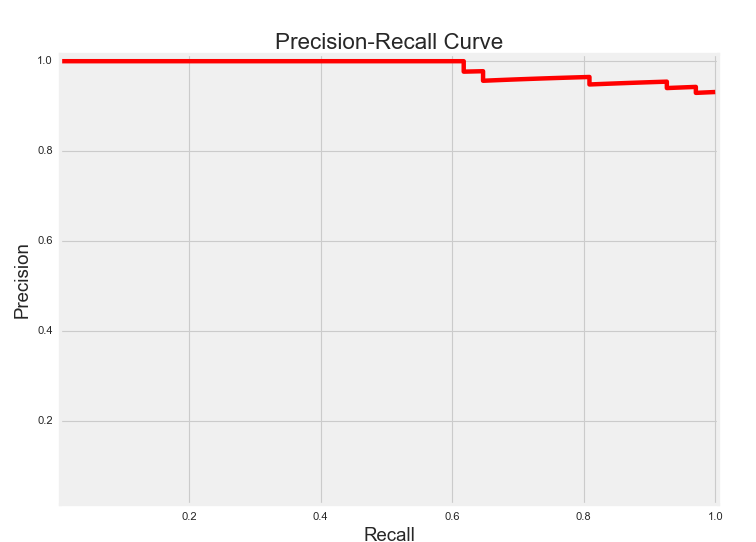

(0, 1)

In [127]:
#Now our precision recall curve

plt.plot(logregRecall, logregPrecision, color='red',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0, 1])
plt.xlim([0, 1])

Finally, let's calculate the area under the curve for each.

In [130]:
from sklearn.metrics import average_precision_score


logregAuc= roc_auc_score(testYBinary,logPredprob[:,1])
average_precision = average_precision_score(testYBinary,logPredprob[:,1])

In [131]:
print 'ROC AUC Score: ', logregAuc
print 'Precision-Recall AUC Score: ', average_precision

ROC AUC Score:  0.990379329302
Precision-Recall AUC Score:  0.982704637906


In [133]:
#Notes from presentations: there's an sklearn function for a scatter matrix (heatmap for corr matrix)
#Look up classification report to get infor about Precision/Recall automatically
#Plot learning curve with sklearn: plot_learning_curve

Write a function to delete a node (except the tail) in a singly linked list, given only access to that node.

Supposed the linked list is 1 -> 2 -> 3 -> 4 and you are given the third node with value 3, the linked list should become 1 -> 2 -> 4 after calling your function.